### Vehicle Detection and Tracking Project

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import glob
import time
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style("white")

#### Data Load

In [3]:
def load_images(file_path):
    images = []
    images_files = glob.glob(file_path)
    for file in images_files:
        img = mpimg.imread(file)
        images.append(img)
    return images
# vehicles = load_images('cls_images/vehicles/*/*.png')
# non_vehicles = load_images('cls_images/non-vehicles/*/*.png')

In [4]:
len(vehicles),len(non_vehicles)

(8792, 8968)

Vehicle images:8792
Non-vehicle images:8968


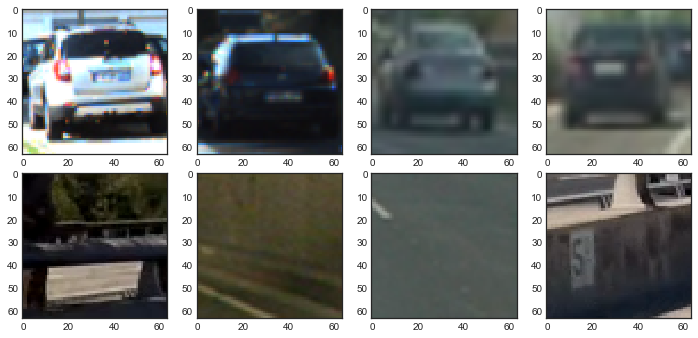

In [5]:

def image_overview():
    idsv=[]
    idsn=[]
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(2, 4, wspace=0.2, hspace=0.01)
    # random plot
    for i in range(4): 
        ids1 = random.randint(0, len(vehicles))
        idsv.append(ids1)
        plt.subplot(gs[i])
        plt.imshow(vehicles[ids1])
    for j in range(4,8):
        ids2 = random.randint(0, len(non_vehicles))
        idsn.append(ids2)
        plt.subplot(gs[j])
        plt.imshow(non_vehicles[ids2])
    print('Vehicle images:{}\nNon-vehicle images:{}'.format(len(vehicles), len(non_vehicles)))
    idsv = np.array(idsv)
    idsn = np.array(idsn)
    #fig.savefig('output_images/data_preview.png', bbox_inches='tight')
    return idsv, idsn
idsv, idsn = image_overview()

### Feature Extraction

The features used for training the classifier:

* Resized raw YCrCb pixel intensities features (32,32).
* Histgram values for all three YCrCb channels.
* HOG features for all three YCrCb channels.

In [6]:
vehicle_imgs = np.array(vehicles)[idsv]
non_vehicle_imgs = np.array(non_vehicles)[idsn]
test_imgs = np.vstack([vehicle_imgs,non_vehicle_imgs])

In [4]:
def get_features(img, color_space='LUV', nbins=64, spatial_size=16, orientations=12, 
                 pix_per_cell=8, cell_per_block=1, train_flag=False):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, (spatial_size,spatial_size)).ravel()
    
    # resize the image to get color hist features
    resized_img = cv2.resize(feature_image, (spatial_size,spatial_size))
    
    # color hist features
    hist_1 = np.histogram(resized_img[:,:,0], bins=nbins)
    hist_2 = np.histogram(resized_img[:,:,1], bins=nbins)
    hist_3 = np.histogram(resized_img[:,:,2], bins=nbins)
    bin_edges = hist_1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    # HOG images for visualizaiton
    if train_flag is False:
        features_check, hog_image_check = hog(feature_image, orientations, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                              cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, 
                                              feature_vector=True, visualize=True, block_norm='L2-Hys')
        return bin_centers, hist_1[0], hist_2[0], hist_3[0], hog_image_check
    # HOG features for training
    else:
        features_1 = hog(feature_image[:, :, 0], orientations, pixels_per_cell=(pix_per_cell,pix_per_cell),
                         cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, feature_vector=True,
                         visualize=False, block_norm='L2-Hys')
        features_2 = hog(feature_image[:, :, 1], orientations, pixels_per_cell=(pix_per_cell,pix_per_cell),
                         cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, feature_vector=True,
                         visualize=False, block_norm='L2-Hys')
        features_3 = hog(feature_image[:, :, 2], orientations, pixels_per_cell=(pix_per_cell,pix_per_cell),
                         cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, feature_vector=True,
                         visualize=False, block_norm='L2-Hys')
    # Append the new feature vector to the features list
        all_features = np.hstack((features, hist_1[0], hist_2[0], hist_3[0], features_1, features_2, features_3))

        return all_features

In [8]:
def feature_visualize(car_img, none_img, color_space, nbins, spatial_size, 
                      orientations, pix_per_cell, cell_per_block, train_flag):
    bin_centers, hist_1, hist_2, hist_3, hog_image_check = get_features(car_img, color_space=color_space, nbins=nbins, 
                                                                        spatial_size=spatial_size,orientations=orientations, 
                                                                        pix_per_cell=pix_per_cell,
                                                                        cell_per_block=cell_per_block, train_flag=False)
    
    bin_centers_no, hist_1_no, hist_2_no, hist_3_no, hog_image_check_no = get_features(none_img, color_space=color_space, nbins=nbins, 
                                                                                    spatial_size=spatial_size,orientations=orientations,
                                                                                    pix_per_cell=pix_per_cell,
                                                                                    cell_per_block=cell_per_block, train_flag=False)

    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 5, wspace=0.15, hspace=0.2)

    plt.subplot(gs[0,0])
    plt.imshow(car_img)
    plt.title('Car RGB')
    plt.subplot(gs[0,1])
    plt.bar(bin_centers, hist_1, 2)
    plt.title('L Channel')
    plt.xlim(0, 256)
    plt.subplot(gs[0,2])
    plt.bar(bin_centers, hist_2, 2)
    plt.title('U Channel')
    plt.xlim(0, 256)
    plt.subplot(gs[0,3])
    plt.bar(bin_centers, hist_3, 2)
    plt.title('V Channel')
    plt.xlim(0, 256)
    plt.subplot(gs[0,4])
    plt.imshow(hog_image_check, 'gray')
    plt.title('HOG feature')
    
    plt.subplot(gs[1,0])
    plt.imshow(none_img)
    plt.title('Car RGB')
    plt.subplot(gs[1,1])
    plt.bar(bin_centers_no, hist_1_no, 2)
    plt.title('L Channel')
    plt.xlim(0, 256)
    plt.subplot(gs[1,2])
    plt.bar(bin_centers_no, hist_2_no, 2)
    plt.title('U Channel')
    plt.xlim(0, 256)
    plt.subplot(gs[1,3])
    plt.bar(bin_centers_no, hist_3_no, 2)
    plt.title('V Channel')
    plt.xlim(0, 256)
    plt.subplot(gs[1,4])
    plt.imshow(hog_image_check_no, 'gray')
    plt.title('HOG feature')
    
    fig.savefig('output_images/features_vis.png', bbox_inches='tight')

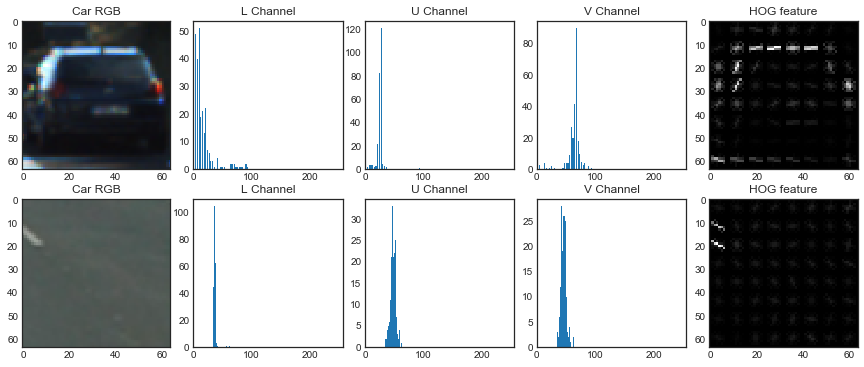

In [9]:
train_flag=False
color_space='LUV'
spatial_size=16
nbins=32
orientations=12
pix_per_cell=8
cell_per_block=1
feature_visualize(test_imgs[1],test_imgs[6],color_space, nbins, spatial_size, 
                  orientations, pix_per_cell, cell_per_block, train_flag)

### Training dataset prepare

In [5]:
def features_generate(imgs, color_space='LUV', nbins=64, spatial_size=16,
                      orientations=12, pix_per_cell=8, cell_per_block=1, train_flag=True):
    features_all = []
    for img in imgs:
        combined_features = get_features(img, color_space=color_space, nbins=nbins, 
                                         spatial_size=spatial_size, 
                                         orientations=orientations, pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, train_flag=train_flag)
        features_all.append(combined_features)
    return features_all

In [5]:
def parameter_trylist():
    nbins_list = [16,32]
    pix_per_cell_list = [8,12]
    cell_per_block_list = [1,2]
    combinelist = [nbins_list, pix_per_cell_list, cell_per_block_list]
    trylist = list(itertools.product(*combinelist))
    return trylist
trylist = parameter_trylist()

In [12]:
def cls_matrix(vehicles, non_vehicles, trylist):
    # append list 
    color_space_=[]
    spatial_size_=[]
    orientations_=[]
    nbins_=[]
    pix_per_cell_=[]
    cell_per_block_=[]
    extract_time_=[]
    vector_length_=[]
    training_time_=[]
    test_acc_=[]
    predict_speed_=[]
    # default parameter
    train_flag=True
    color_space='LUV'
    spatial_size=16
    orientations=12
    # parameter try list
    for trypara in trylist:
        nbins = trypara[0]
        pix_per_cell = trypara[1]
        cell_per_block = trypara[2]
        
        start_time = time.time()
        car_X_features = features_generate(vehicles, color_space, nbins, spatial_size, 
                                           orientations, pix_per_cell, cell_per_block, train_flag)
        not_X_features = features_generate(non_vehicles, color_space, nbins, spatial_size, 
                                           orientations, pix_per_cell, cell_per_block, train_flag)
        car_X = np.array(car_X_features)
        not_X = np.array(not_X_features)
        car_Y = np.ones(len(vehicles))
        not_Y = np.zeros(len(non_vehicles))
        end_time = time.time()
        extract_time = round(end_time-start_time,2)
        print('Done! Extraction Time: {} seconds'.format(extract_time))
        X = np.vstack((car_X, not_X))
        y = np.hstack((car_Y, not_Y))
        # Train/Test Split
        # Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 1000))
        X_scaler = StandardScaler().fit(X_train)
        # Apply the scaler to X_train and X_test
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)
        vector_length = len(X_train[0])
        print('Spatial size: ',spatial_size)
        print('Orientations: ',orientations)
        print('Histogram bins: ', nbins)
        print('pix_per_cell: ', pix_per_cell)
        print('cell_per_block: ', cell_per_block)
        print('Vector length:', vector_length)
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t = time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print('Training time: ',round(t2-t, 2))
        # Check the score of the SVC
        print('Test Accuracy: ', round(svc.score(X_test, y_test), 5))
        t3=time.time()
        n_predict = 1000
        svc.predict(X_test[0:n_predict])
        t4 = time.time()
        print('Predict speed: ',round(t4-t3, 5), 'seconds', 'for {} samples'.format(n_predict))
        print('')
        
        Training_time = round(t2-t,2)
        test_acc = round(svc.score(X_test, y_test), 5)
        predict_speed = round(t4-t3, 5)
        
        color_space_.append(color_space)
        spatial_size_.append(spatial_size)
        orientations_.append(orientations)
        nbins_.append(nbins)
        pix_per_cell_.append(pix_per_cell)
        cell_per_block_.append(cell_per_block)
        extract_time_.append(extract_time)
        vector_length_.append(vector_length)
        training_time_.append(Training_time)
        test_acc_.append(test_acc)
        predict_speed_.append(predict_speed)
        
    performance_matrix=np.vstack((color_space_, spatial_size_, nbins_, orientations_, 
                                  pix_per_cell_, cell_per_block_, extract_time_, vector_length_,
                                  training_time_, test_acc_, predict_speed_)).T
    return performance_matrix

In [103]:
performance_matrix = cls_matrix(vehicles, non_vehicles, trylist)

Done! Extraction Time: 77.89 seconds
Spatial size:  16
Orientations:  12
Histogram bins:  16
pix_per_cell:  8
cell_per_block:  1
Vector length: 3120
Training time:  7.96
Test Accuracy:  0.98705
Predict speed:  0.00499 seconds for 1000 samples

Done! Extraction Time: 98.98 seconds
Spatial size:  16
Orientations:  12
Histogram bins:  16
pix_per_cell:  8
cell_per_block:  2
Vector length: 7872
Training time:  10.83
Test Accuracy:  0.99043
Predict speed:  0.01197 seconds for 1000 samples

Done! Extraction Time: 111.77 seconds
Spatial size:  16
Orientations:  12
Histogram bins:  16
pix_per_cell:  12
cell_per_block:  1
Vector length: 1716
Training time:  5.44
Test Accuracy:  0.98423
Predict speed:  0.002 seconds for 1000 samples

Done! Extraction Time: 49.35 seconds
Spatial size:  16
Orientations:  12
Histogram bins:  16
pix_per_cell:  12
cell_per_block:  2
Vector length: 3120
Training time:  6.24
Test Accuracy:  0.98846
Predict speed:  0.00499 seconds for 1000 samples

Done! Extraction Time:

In [104]:
import pandas as pd
pd.DataFrame(performance_matrix)

0   1   2   3   4  5       6     7      8        9        10
0  LUV  16  16  12   8  1   77.89  3120   7.96  0.98705  0.00499
1  LUV  16  16  12   8  2   98.98  7872  10.83  0.99043  0.01197
2  LUV  16  16  12  12  1  111.77  1716   5.44  0.98423    0.002
3  LUV  16  16  12  12  2   49.35  3120   6.24  0.98846  0.00499
4  LUV  16  32  12   8  1   82.79  3168   9.95   0.9862  0.00499
5  LUV  16  32  12   8  2  114.67  7920   6.16  0.99015  0.01396
6  LUV  16  32  12  12  1   106.9  1764   6.05  0.98536  0.00299
7  LUV  16  32  12  12  2   71.63  3168   6.85  0.98677  0.00499

### Training the Classifier

In [6]:
# Default parameters choose
train_flag=True
color_space='LUV'
spatial_size=16
nbins=16
orientations=12
pix_per_cell=8
cell_per_block=1

In [14]:
start_time = time.time()
car_X_features = features_generate(vehicles, color_space, nbins, spatial_size, 
                                   orientations, pix_per_cell, cell_per_block, train_flag)
not_X_features = features_generate(non_vehicles, color_space, nbins, spatial_size, 
                                   orientations, pix_per_cell, cell_per_block, train_flag)
car_X = np.array(car_X_features)
not_X = np.array(not_X_features)
car_Y = np.ones(len(vehicles))
not_Y = np.zeros(len(non_vehicles))
end_time = time.time()
print('Done! Extraction Time Used: {} seconds'.format(round(end_time-start_time,2)))

Done! Extraction Time Used: 78.85 seconds


In [15]:
X = np.vstack((car_X, not_X))
y = np.hstack((car_Y, not_Y))

In [16]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial_size,
    'and', nbins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using spatial binning of: 16 and 16 histogram bins
Feature vector length: 3120
6.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9876


In [6]:
import pickle

In [19]:
pickle.dump(svc, open('svm_model.p', 'wb'))
pickle.dump(X_scaler, open('X_scaler.p', 'wb'))

In [7]:
svc = pickle.load(open('svm_model.p', 'rb'))
X_scaler = pickle.load(open('X_scaler.p', 'rb'))

### Window search

In [8]:
test_images = load_images('test_images/*.jpg')
test_images = np.array(test_images)

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop, 
              orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all = False):
    
    img = img.astype(np.float32)/255
    # roi cutoff
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    # all channels HOG 
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)
    nyblocks = (ch1.shape[0] // pix_per_cell) 
    nfeat_per_block = orientations*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = hog(ch1, orientations, pixels_per_cell=(pix_per_cell,pix_per_cell),
                     cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, feature_vector=False,
                     visualize=False, block_norm='L2-Hys')
    hog2 = hog(ch2, orientations, pixels_per_cell=(pix_per_cell,pix_per_cell),
                     cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, feature_vector=False,
                     visualize=False, block_norm='L2-Hys')
    hog3 = hog(ch3, orientations, pixels_per_cell=(pix_per_cell,pix_per_cell),
                     cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, feature_vector=False,
                     visualize=False, block_norm='L2-Hys')
    
    rectangles = []
   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
 
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = cv2.resize(subimg, (spatial_size,spatial_size)).ravel()
            # resize the image to get color hist features
            resized_img = cv2.resize(subimg, (spatial_size,spatial_size))
            # color hist features
            channel1_hist = np.histogram(resized_img[:,:,0], bins=nbins)
            channel2_hist = np.histogram(resized_img[:,:,1], bins=nbins)
            channel3_hist = np.histogram(resized_img[:,:,2], bins=nbins)

            # Concatenate the histograms into a single feature vector
            hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
            
            all_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)

            # Scale features and make a prediction
            test_features = X_scaler.transform(all_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
  
            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return rectangles

In [10]:
# Define a function to draw bounding boxes# Define 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
# Default parameters choose
color_space='LUV'
spatial_size=16
nbins=16
orientations=12
pix_per_cell=8
cell_per_block=1
# roi
xstart = 0
xstop = 1280
ystart = 400
ystop = 656
scale=2

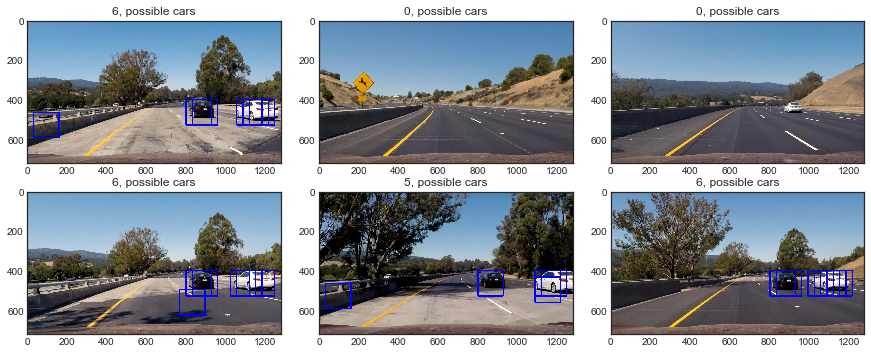

In [12]:
def res_vis(test_images, xstart, xstop, ystart, ystop, scale):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop, 
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=False)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.title('{}, possible cars'.format(len(rectangles)))
        plt.imshow(rect_on_image)
        #fig.savefig('output_images/detected_res.png', bbox_inches='tight')
res_vis(test_images, xstart, xstop, ystart, ystop, scale)

* There are some false positive show above. The ROI and multiple searching window should be used to make the model more robust

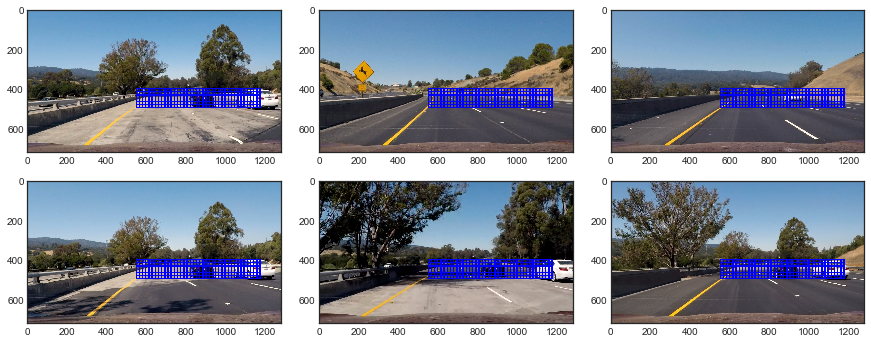

In [17]:
# The first ROI
xstart = 550
xstop = 1200
ystart = 400
ystop = 520
scale = 1.0
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop, 
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=True)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

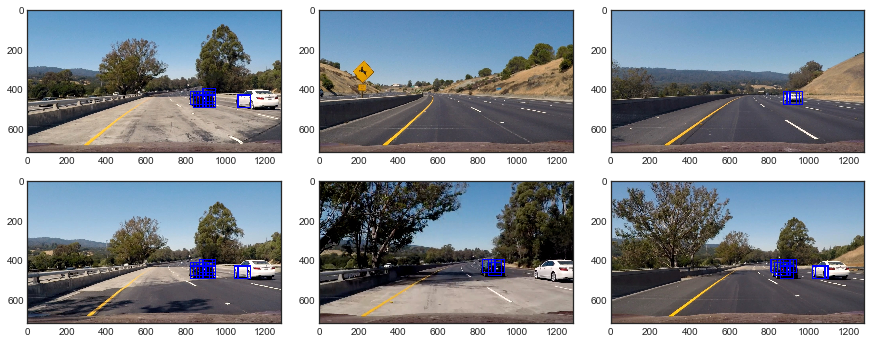

In [18]:
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=False)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

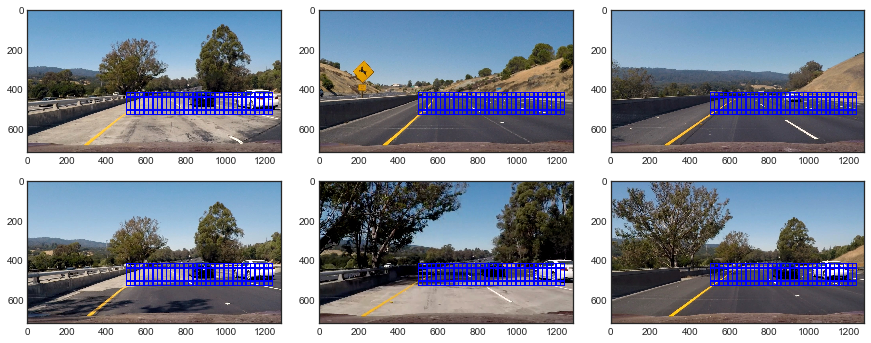

In [53]:
# The Second ROI
xstart = 500
xstop = 1280
ystart = 420
ystop = 560
scale = 1.4
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop, 
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=True)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

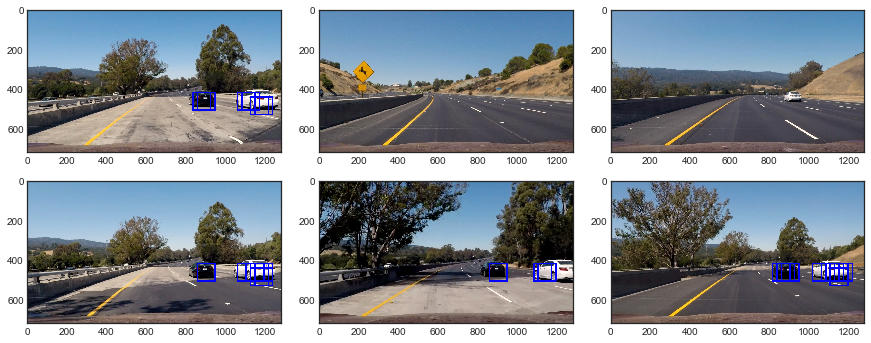

In [54]:
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=False)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

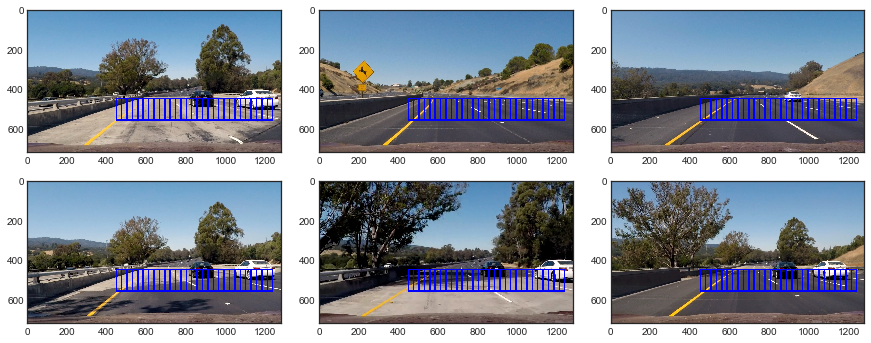

In [22]:
# The Third ROI
xstart = 450
xstop = 1280
ystart = 450
ystop = 590
scale = 1.7
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop, 
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=True)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

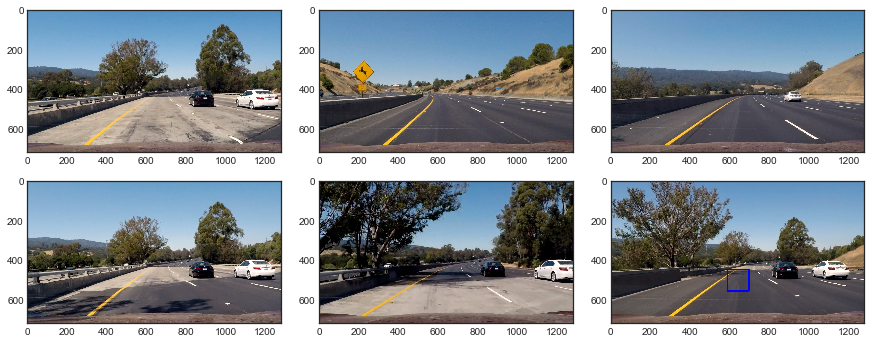

In [23]:
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=False)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

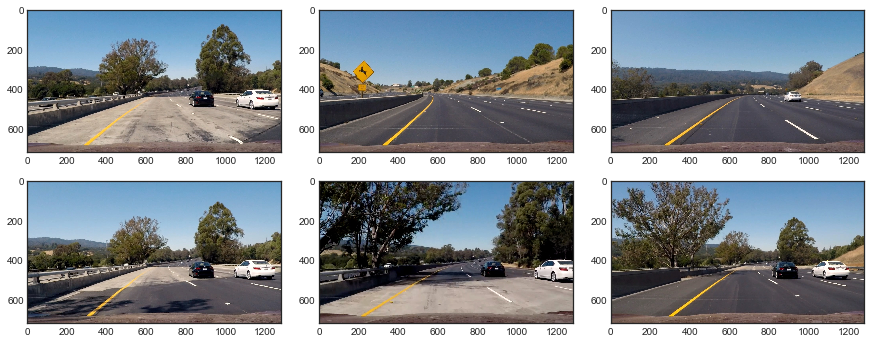

In [34]:
# The Forth ROI
xstart = 600
xstop = 1280
ystart = 490
ystop = 656
scale = 2.2
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop, 
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=True)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

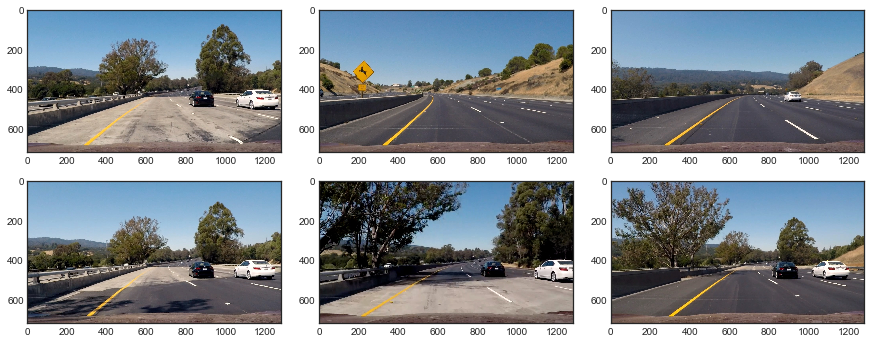

In [35]:
def window_range(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = find_cars(test_images[i], ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                               orientations, pix_per_cell, cell_per_block, spatial_size, nbins, show_all=False)
        rect_on_image = draw_boxes(test_images[i],rectangles)
        plt.subplot(gs[i])
        plt.imshow(rect_on_image)
window_range()

In [58]:
def apply_sliding_window(img):
    rectangles = []
    # Fisrt ROI
    xstart = 550
    xstop = 1200
    ystart = 400
    ystop = 520
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                                orientations, pix_per_cell, cell_per_block, spatial_size, nbins))
    # Second ROI
    xstart = 500
    xstop = 1280
    ystart = 420
    ystop = 560
    scale = 1.4
    rectangles.append(find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                                orientations, pix_per_cell, cell_per_block, spatial_size, nbins))
    
    # The Third ROI
    xstart = 450
    xstop = 1280
    ystart = 450
    ystop = 590
    scale = 1.7
    rectangles.append(find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                                orientations, pix_per_cell, cell_per_block, spatial_size, nbins))    
    # Forth ROI
    xstart = 600
    xstop = 1280
    ystart = 490
    ystop = 656
    scale = 2.2
    rectangles.append(find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, xstart, xstop,
                                orientations, pix_per_cell, cell_per_block, spatial_size, nbins))
     
    return rectangles

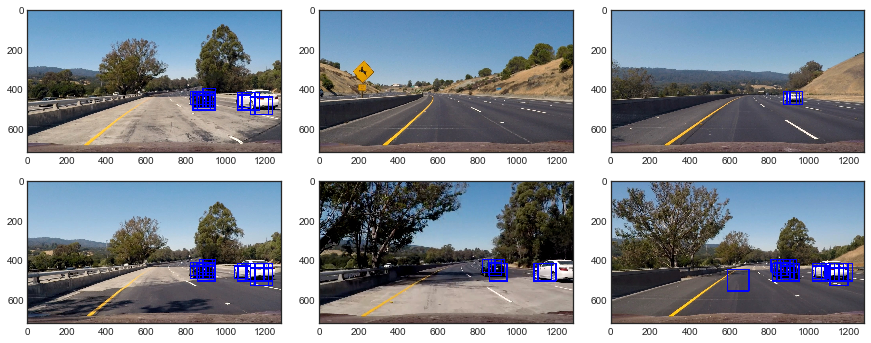

In [59]:
def many_windows(images=test_images):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = apply_sliding_window(test_images[i])
        rectangles = [item for sublist in rectangles for item in sublist]
        rects_on_image = draw_boxes(test_images[i], rectangles)
        plt.subplot(gs[i])
        plt.imshow(rects_on_image)
        fig.savefig('output_images/many_windows.png', bbox_inches='tight')
many_windows()

In [60]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

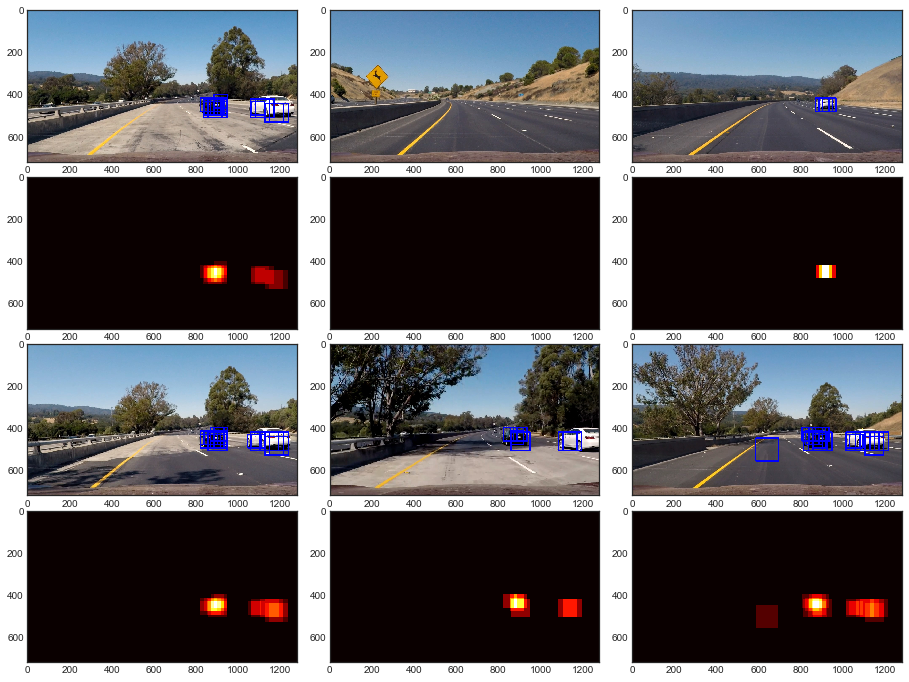

In [61]:
def heatmap_windows(images=test_images):
    fig = plt.figure(figsize=(16,12))
    gs = gridspec.GridSpec(4, 3, wspace=0.05, hspace=0.1)
    for i in range(len(test_images)):
        rectangles = apply_sliding_window(test_images[i])
        rectangles = [item for sublist in rectangles for item in sublist]
        rects_on_image = draw_boxes(test_images[i], rectangles)
        heatmap_img = np.zeros_like(test_images[i][:,:,0])
        heatmap_img = add_heat(heatmap_img, rectangles)
        plt.subplot(gs[2*int(i/3), i%3])
        plt.imshow(rects_on_image)
        plt.subplot(gs[2*int(i/3)+1, i%3])
        plt.imshow(heatmap_img,cmap='hot')
        fig.savefig('output_images/heatmap_img.png', bbox_inches='tight')
    return heatmap_img
heatmap_img = heatmap_windows()

In [62]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [63]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

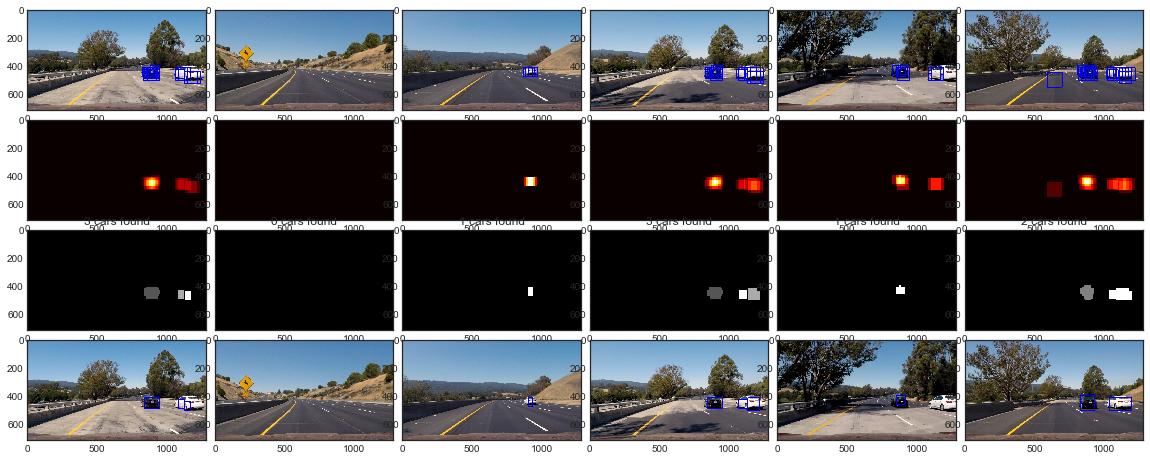

In [64]:
from scipy.ndimage.measurements import label
def threshold_label(images=test_images):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(4, 6, wspace=0.05, hspace=0.05)
    for i in range(len(test_images)):
        rectangles = apply_sliding_window(test_images[i])
        rectangles = [item for sublist in rectangles for item in sublist]
        rects_on_image = draw_boxes(test_images[i], rectangles)
        heatmap_img = np.zeros_like(test_images[i][:,:,0])
        heatmap_img = add_heat(heatmap_img, rectangles)
        heatmap1 = heatmap_img.copy()
        heatmap = apply_threshold(heatmap1, 2)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(test_images[i]), labels)
        plt.subplot(gs[int(i/6), i%6])
        plt.imshow(rects_on_image)
        plt.subplot(gs[int(i/6)+1, i%6])
        plt.imshow(heatmap_img, cmap='hot')
        plt.subplot(gs[int(i/6)+2, i%6])
        plt.imshow(labels[0], cmap='gray')
        plt.title('{} cars found'.format(labels[1]))
        plt.subplot(gs[int(i/6)+3, i%6])
        plt.imshow(draw_img)
        fig.savefig('output_images/labeled_heatmap.png', bbox_inches='tight')
threshold_label()

In [65]:
# Define a class to store data from video
class Vehicles():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [68]:
from scipy.ndimage.measurements import label
def video_pipeline(img):
    rectangles = apply_sliding_window(img)
    rectangles = [item for sublist in rectangles for item in sublist]
    rects_on_image = draw_boxes(img, rectangles)
    # add detections to the history
    if len(rectangles) > 0:
        vehicle_detect.add_rects(rectangles)
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in vehicle_detect.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap1 = heatmap_img.copy()
    heatmap = apply_threshold(heatmap1, 5)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    heatmap_ = np.copy(heatmap)
    heatmap_ = np.dstack((heatmap_, heatmap_, heatmap_))*255

    mixed_screen = np.zeros((1080, 1280,3), dtype=np.uint8)
    mixed_screen[0:720, 0:1280] = draw_img
    mixed_screen[720:1080, 0:640] = cv2.resize(rects_on_image, (640,360), interpolation=cv2.INTER_AREA) 
    mixed_screen[720:1080, 640:1280] = cv2.resize(heatmap_, (640,360), interpolation=cv2.INTER_AREA)
    return mixed_screen

In [39]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle_detect = Vehicles()

test_output = 'output_video/test_video_output.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_output = clip_test.fl_image(video_pipeline)
%time clip_test_output.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_video/test_video_output.mp4
[MoviePy] Writing video output_video/test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:12<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/test_video_output.mp4 

Wall time: 13.9 s


In [69]:
# project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle_detect = Vehicles()

project_output = 'output_video/project_video_output3.mp4'
clip_project = VideoFileClip('project_video.mp4')
clip_project_output = clip_project.fl_image(video_pipeline)
%time clip_project_output.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video_output3.mp4
[MoviePy] Writing video output_video/project_video_output3.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:53<00:00,  3.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output3.mp4 

Wall time: 6min 54s
